# Overview
The notebook uses the [CONX package](https://github.com/Calysto/conx) from [Douglas Blank](https://cs.brynmawr.edu/~dblank/) and the Calysto team to show how the basic U-Net architecture works on segmentation problems. We use a simple toy problem described below and study how our MiniUNET architecture handles the problem. 

## Note 
This is not 'real' U-Net since it does not have the proper cropping layers nor the correct size and depth (Ronneberger trained the original model using 512x512 images and having many more layers of max-pooling and upsampling).  The cropping layers are important as well since edges can skew the weights in the convolutions and cause the algorithm to converge slowly or with small enough windows incorrectly

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
base_img_dims = (48, 48)
RAND_IMG_TYPE = 'color_holes'

# Generate Training Data
Here we make training data using shapes. We have a number of possiblities for training data below, the example we show here is the ```color_holes``` where we have a number of different types of holes and corresponding segments that we wish to extract
- red rings $\longrightarrow$ filled circles
- green circles $\longrightarrow$  filled circles
- blue squares $\longrightarrow$  filled circles
- blue circles $\longrightarrow$  empty circles

In [2]:
from skimage.morphology import convex_hull_image, binary_closing, disk, binary_erosion
from skimage.filters import gaussian
if RAND_IMG_TYPE=='holes':
    def g_random_img():
        xx, yy = np.meshgrid(np.linspace(-1, 1, base_img_dims[0]),
                   np.linspace(-1, 1, base_img_dims[1]))

        r_img = np.random.uniform(-1, 1, size = base_img_dims+(1,))
        out_mask = np.zeros(base_img_dims)
        for _ in range(np.random.choice([1, 2, 4])):
            r_x, r_y = np.random.uniform(-1, 1, size = (2,))
            r_c = np.random.uniform(0.1, .6)
            n_mask = (np.square(xx-r_x)+np.square(yy-r_y))<np.square(r_c)
            ed_mask = n_mask^binary_erosion(n_mask, disk(1))
            ed_mask = ((np.square(xx-r_x)+np.square(yy-r_y))<np.square(r_c))
            ed_mask &= (((np.square(xx-r_x)+np.square(yy-r_y))>(np.square(r_c-0.05))))
            r_img[ed_mask, 0] = 2
            out_mask += n_mask
        f_img = gaussian(r_img, [1, 1], multichannel = True, mode = 'reflect')
        return np.clip(f_img*127+127, 0, 255).astype(np.uint8), np.clip(np.expand_dims(out_mask,-1),0,1)
elif RAND_IMG_TYPE=='color_holes':
    def g_random_img():
        xx, yy = np.meshgrid(np.linspace(-1, 1, base_img_dims[0]),
                   np.linspace(-1, 1, base_img_dims[1]))

        r_img = np.random.uniform(-1, 1, size = base_img_dims+(3,))
        r_img[r_img>0.9] = 2
        r_img = gaussian(r_img, [3, 1], multichannel = True, mode = 'reflect')
        out_mask = np.zeros(base_img_dims)
        for _ in range(np.random.choice([3, 4, 5])):
            r_x, r_y = np.random.uniform(-1, 1, size = (2,))
            r_c = np.random.uniform(0.15, .6)
            n_mask = (np.square(xx-r_x)+np.square(yy-r_y))<np.square(r_c)
            sq_mask = (np.abs(xx-r_x)<r_c) & (np.abs(yy-r_y)<r_c)
            ed_mask = n_mask^binary_erosion(n_mask, disk(1))
            ed_mask = ((np.square(xx-r_x)+np.square(yy-r_y))<np.square(r_c))
            ed_mask &= (((np.square(xx-r_x)+np.square(yy-r_y))>(np.square(r_c-0.075))))
            ch_out = np.random.choice(range(3))
            
            if ch_out==0:
                # red
                mask1 = ed_mask
                mask2 = n_mask
            elif ch_out==1:
                # green
                mask1 = n_mask
                mask2 = n_mask
            else:
                # blue
                if np.random.choice([0,1])>0:
                    mask1 = sq_mask
                    mask2 = sq_mask
                else:
                    mask1 = n_mask
                    mask2 = np.zeros_like(n_mask)
                    out_mask -= n_mask
            r_img[mask1, ch_out] = 2
            out_mask += mask2
        f_img = gaussian(r_img, [1, 1], multichannel = True, mode = 'reflect')
        return np.clip(f_img*127+127, 0, 255)/255.0, np.clip(np.expand_dims(out_mask,-1),0,1)
elif RAND_IMG_TYPE=='flow':
    def g_random_img():
        r_img = np.random.uniform(-1, 1, size = base_img_dims+(1,))
        f_img = gaussian(r_img, [4, 3], 
                         multichannel = True, 
                         mode = 'reflect')
        g_img = gaussian(
            f_img + np.random.uniform(-0.2, 0.2, size = base_img_dims+(1,)),
            [1, 1], 
            multichannel = True, 
            mode = 'reflect')
        thresh_val = np.percentile(f_img.ravel(), 50)
        print(thresh_val)
        n_mask = f_img[:,:,0]>thresh_val
        n_mask = binary_closing(n_mask, disk(1))
        return np.clip(g_img, -1, 1), np.expand_dims(n_mask,-1)
elif RAND_IMG_TYPE=='color_dots':
    def g_random_img():
        xx, yy = np.meshgrid(np.linspace(-1, 1, base_img_dims[0]),
                   np.linspace(-1, 1, base_img_dims[1]))

        r_img = np.random.uniform(-1, 1, size = base_img_dims+(3,))
        r_x, r_y = np.random.uniform(-1, 1, size = (2,))
        r_c = int(np.random.uniform(0, 3))
        n_mask = (np.square(xx-r_x)+np.square(yy-r_y))<np.square(0.25)
        r_img[n_mask, r_c] = 1.5
        f_img = gaussian(r_img, [4, 3], multichannel = True, mode = 'reflect')
        return np.clip(f_img*127+127, 0, 255).astype(np.uint8), np.expand_dims(n_mask,-1)

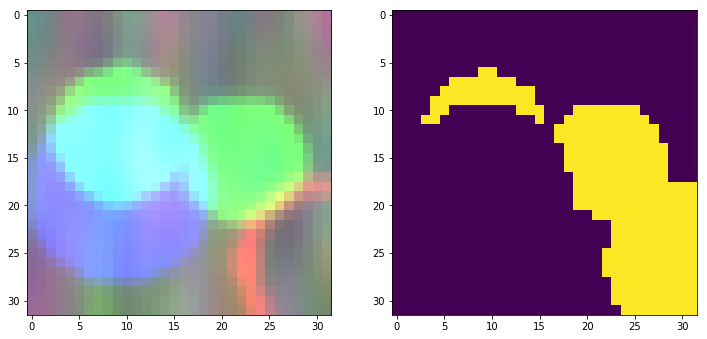

In [3]:
np.random.seed(2021)
t_img, m_img = g_random_img()
fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(np.clip(255*t_img, 0, 255).astype(np.uint8) if t_img.shape[2]==3 else t_img[:,:,0], interpolation = 'none')
ax_mask.imshow(m_img[:,:,0])

In [4]:
import conx as cx

Using TensorFlow backend.
Conx, version 3.6.3


In [5]:
net = cx.Network("MiniUNet")
base_depth = 8

In [6]:
net.add(cx.ImageLayer("input", base_img_dims, t_img.shape[-1])) 
net.add(cx.BatchNormalizationLayer("bnorm"))
c2 = lambda i, j, act = "relu": cx.Conv2DLayer("conv_{}".format(i, j), j, (3, 3), padding='same', activation=act)
net.add(c2(0, base_depth))
net.add(c2(1, base_depth))
net.add(cx.MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(c2(2, 2*base_depth))
net.add(c2(3, 2*base_depth))
net.add(cx.MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(c2(4, 4*base_depth))
net.add(c2(5, 4*base_depth))
net.add(cx.UpSampling2DLayer("up2", size = (2,2)))
net.add(cx.ConcatenateLayer("cat2"))
net.add(c2(6, 2*base_depth))
net.add(c2(7, 2*base_depth))
net.add(cx.UpSampling2DLayer("up1", size = (2,2)))
net.add(cx.ConcatenateLayer("cat1"))
net.add(c2(8, 2*base_depth))
net.add(cx.Conv2DLayer("output", 1, (1, 1), padding='same', activation='sigmoid'));

# Connections
We have to connect all of the layers together in a U-Net style. The tricky part is the skip connections that skip over the max pooling layers and go directly to the concatenate to combine the higher resolution information with the lower resolution feature space

In [7]:
net.connect('input', 'bnorm')
net.connect('bnorm', 'conv_0')
net.connect('bnorm', 'cat1')
net.connect('conv_0', 'conv_1')

In [8]:
net.connect('conv_1', 'pool1')
net.connect('pool1', 'conv_2')
net.connect('conv_2', 'conv_3')
net.connect('conv_3', 'pool2')
net.connect('pool2', 'conv_4')
net.connect('conv_4', 'conv_5')
net.connect('conv_5', 'up2')
net.connect('up2', 'cat2')
net.connect('conv_3', 'cat2')
net.connect('cat2', 'conv_6')
net.connect('conv_6', 'conv_7')
net.connect('conv_7', 'up1')
net.connect('up1', 'cat1')
net.connect('cat1', 'conv_8')
net.connect('conv_8', 'output')

In [9]:
net.compile(error="binary_crossentropy", optimizer="adam")

         but not using the 'softmax' activation function on layer 'output'


# Untrained Network
Here we show the untrained network on the test image. 

<IPython.core.display.Javascript object>


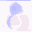
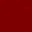
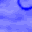
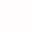
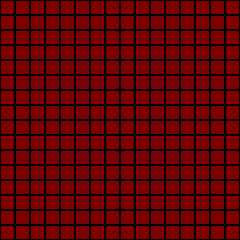
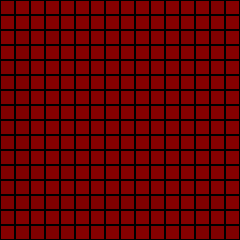
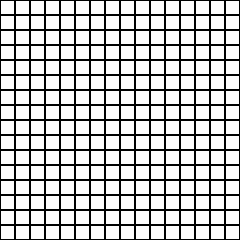
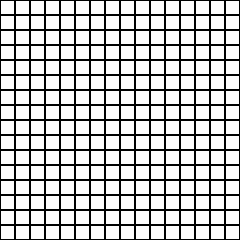
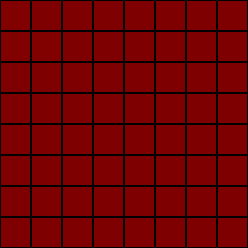
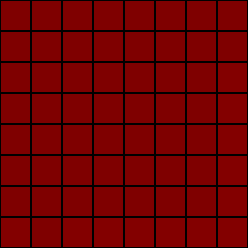
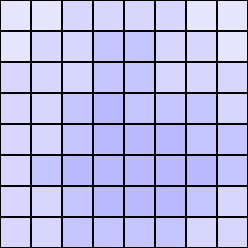
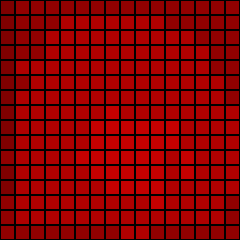
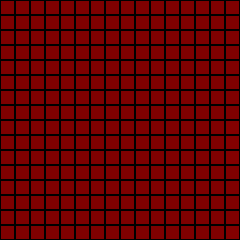
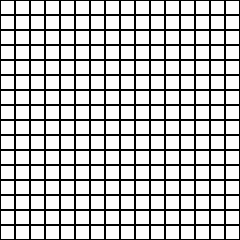
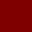
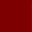
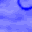
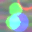

In [10]:
net.picture(t_img, dynamic = True, rotate = True, scale = 1.25)

In [11]:
net.dataset.clear()
ip_pairs = []
for _ in range(500):
    in_vals, out_vals = g_random_img()
    ip_pairs+= [(in_vals, out_vals)]
net.dataset.append(ip_pairs)
net.dataset.split(0.25)

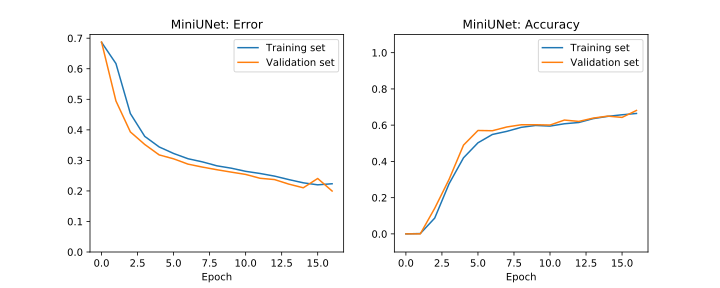

In [ ]:
net.train(epochs=15, record=True)

In [ ]:
net.movie(lambda net, epoch: net.propagate_to_image("output", t_img, scale = 3), 
                'output.gif', mp4 = False)

In [ ]:
net.dashboard()